## Homework 5 (ASTR8060)
#### Niana Mohammed
#### April 5 2021

In [1]:
# importing basic packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits as fits

### 1. Making a master flat
#### Making a master flat is a slightly different process than making a master bias. Here, we examine the flat field images for the V filter, compare the average light levels in the frames, and look for the best way to combine these flat images. 
Before doing anything with the flats we'll overscan subtract, trim, and bias subtract the images and examine them.

In [2]:
# Overscan subtraction and trimming
from ccdproc import subtract_overscan
from ccdproc import trim_image
from astropy.nddata import CCDData
from ccdproc import subtract_bias
from astropy.modeling import models, fitting
from astropy.modeling.polynomial import Legendre1D as leg

# making a list of the paths of the V filter flats 
flat_list = ["Imaging/a0"+str(i)+".fits" for i in np.arange(43,50,1)]
# opening them as ccddata
flat_data = [CCDData(fits.open(file)[0].data, unit='adu') for file in flat_list]

# doing the same for the biases
bias_list = np.hstack([["Imaging/a0"+str(i)+".fits" for i in np.arange(93,100,1)],
                             ["Imaging/a"+str(i)+".fits" for i in np.arange(100,112,1)]])

# subtract overscan and trim
# from homework4, we had settled to characterize the overscan region using a legendre 
# polynomial of degree 4.
mc2 = leg(4)
flat_scan = [subtract_overscan(flat_data[i], overscan=flat_data[i][:, 2101:2200],model=mc2) for i in range(len(flat_data))]
flats = [trim_image(flat_scan[i][:, 53:2101]) for i in range(len(flat_scan))]

bias_data = [CCDData(fits.open(file)[0].data, unit='adu') for file in bias_list]
bias_scan = [subtract_overscan(bias_data[i], overscan=bias_data[i][:, 2101:2200],model=mc2) for i in range(len(bias_data))]
biases = [trim_image(bias_scan[i][:, 53:2101]) for i in range(len(bias_scan))]

Below is a function to save reduced data, so they can be easily accessed when needed. 

In [3]:
def save_reduced(ranges,reduced,prefix,suffix):
    for i in ranges:
        for j in reduced:
            fits.writeto('reduced/'+prefix+str(i)+suffix+'.fits',np.array(j),overwrite=True)
    return

# save the overscan subtracted and trimmed biases
# 'o' & 't' correspond to overscan subtracted and trimmed respectively
save_reduced(np.arange(93,100,1),biases[0:7],'b0','ot')
save_reduced(np.arange(100,112,1),biases[7:],'b','ot')

To do the bias subtraction, we need to make a master bias. Here, we use three different combination methods for comparison. As the histograms and difference images below demonstrate, we'll need to combine our biases using an average with sigma clipping due to the presence of some hot pixels.

In [4]:
import ccdproc
from astropy.stats import mad_std

# doing a straight average for comparison
master_bias1 = ccdproc.combine(biases, method='average')
# choosing a large sigma of 50
master_bias2 = ccdproc.combine(biases, method='average', sigma_clip=True, 
                             sigma_clip_low_thresh=50, sigma_clip_high_thresh=50,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
# choosing a smaller sigma for comparison
master_bias3 = ccdproc.combine(biases, method='average', sigma_clip=True, 
                             sigma_clip_low_thresh=3, sigma_clip_high_thresh=3,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)

Text(0.5, 1.0, 'difference image for 3 sigma')

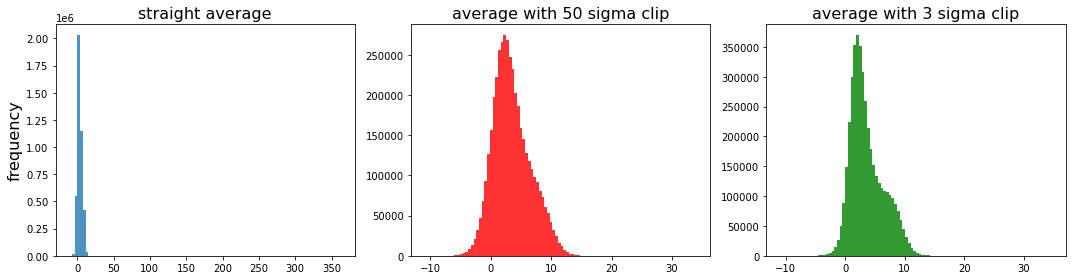

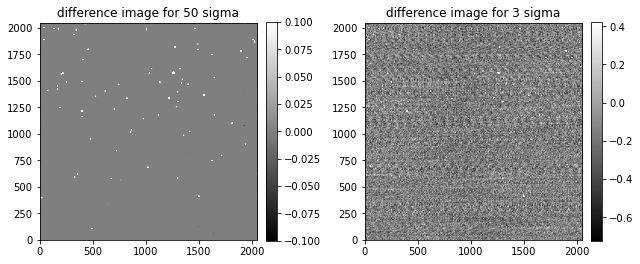

In [5]:
import sys
sys.path.insert(0,'./git_codes/ccd-reduction-and-photometry-guide/notebooks/')
from convenience_functions import show_image

# plotting histograms to see effect of sigma clip
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4), tight_layout=True)
ax1.hist(np.array(master_bias1).flatten(),bins=100,alpha=0.8)
ax2.hist(np.array(master_bias2).flatten(),color='r',bins=100,alpha=0.8)
ax3.hist(np.array(master_bias3).flatten(),color='g',bins=100,alpha=0.8)
ax1.set_title('straight average',fontsize=16)
ax2.set_title('average with 50 sigma clip',fontsize=16)
ax3.set_title('average with 3 sigma clip',fontsize=16)
ax1.set_ylabel('frequency',fontsize=16)

# taking difference images to see what the sigma clip is removing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4), tight_layout=True)
show_image(np.subtract(master_bias1,master_bias2), cmap='gray', ax=ax1, fig=fig)
show_image(np.subtract(master_bias1,master_bias3), cmap='gray', ax=ax2, fig=fig)
ax1.set_title('difference image for 50 sigma',fontsize=12)
ax2.set_title('difference image for 3 sigma',fontsize=12)

# can also do ratio images instead of difference images; would reach same conclusion
#show_image(np.divide(master_bias1, master_bias2), cmap='gray', ax=ax1, fig=fig)
#show_image(np.divide(master_bias1, master_bias3), cmap='gray', ax=ax2, fig=fig)

From the histograms, we can see that a straight average is not doing a good job of removing outlier pixel values. The histograms for average with 50 and 3 sigma clip look better but are not easy to tell apart. However, from the difference images––subtracting the 50 & 3 sigma clipped master biases from the straight average master bias––we can see that 3 sigma is too small and seems to be artificially removing read noise (what most of a bias is). We only want hot pixels to be removed, and as seen in the image, 50 sigma is just large enough to remove those pixels. We will therefore use 'master_bias2' as our master bias to be subtracted from the flats. 

In [6]:
#subtracting the master bias from each of the overscan subtracted & trimmed flats
master_bias = master_bias2
sub_flat = [np.subtract(i,master_bias) for i in flats]

In [7]:
# save the overscan subtracted, trimmed, and bias subtracted flats
# 'z' corresponds to bias subtracted
save_reduced(np.arange(43,50,1),sub_flat,'a0','otz')

Now let us look for artifacts in the V filter flats that could affect the way we combine them. Instead of displaying each of our V filter flat images, let's average them as they are and examine the combination image (straight averaging does not remove any artifacts, so we should be able to see them in the image if they exist). 

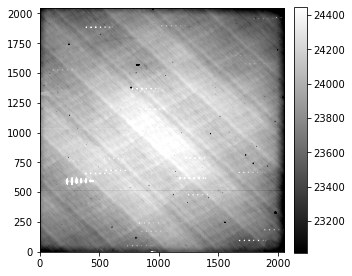

In [8]:
sub_flat1 = [CCDData(i, unit="adu") for i in sub_flat]
combined_flats = ccdproc.combine(sub_flat1, method='average')

fig, axes = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
show_image(combined_flats, cmap='gray', ax=axes, fig=fig)

It looks like there are stars in our flats which need to be removed. We want our flats to be images of uniform illumination, so our master flat should be formed such that the signs of dithering seen above are removed. 

Let's do one more test to see how much variation there is from one flat frame to another. We'll compare the average light levels in our V flats to see how they change with time. 

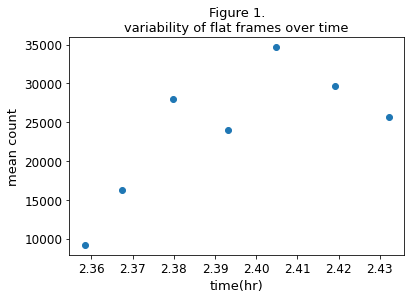

In [9]:
# getting date and time from the headers
datetime = [fits.getheader(i)["DATE-OBS"] for i in flat_list]

# remove the date part from datetime
time = [i[11:] for i in datetime]

# function to convert time to hours
def hour(time_str):
    # get time in hours
    h, m, s = time_str.split(':')
    return int(h) + int(m)/60 +int(float(s))/3600

time_hrs = [hour(i) for i in time]

# take the mean of each of the flats
flat_means = [np.mean(data) for data in sub_flat]

plt.scatter(time_hrs,flat_means)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
plt.xlabel("time(hr)",fontsize=13)
plt.ylabel("mean count",fontsize=13)
plt.title("Figure 1.\nvariability of flat frames over time",fontsize=13) 
plt.show()

It looks like there is much variation in the average light levels of the flats. The flats have varying exoposure times, so the variation would not have been expected to be little. Therefore, to combine them we will first have to scale them to a common level, then combine using some weighting. This will account for the difference in signal levels evident in the plot above.

Now let's scale the flats to a common mean, and discuss the advantages/disadvantages of making a master flat field image using a straight average, straight median, average with sigma clipping (2$\sigma$), and a sigma clipped weighted mean. The scaling is important because if the flats are not scaled before sigma clipping, we could clip whole images. 

In [10]:
# scaling each frame by its mean 
scaled_flats = [CCDData(i/np.mean(i), unit="adu") for i in sub_flat1]

In [11]:
# doing a straight average
master1 = ccdproc.combine(scaled_flats, method='average')
# doing a straight median
master2 = ccdproc.combine(scaled_flats, method='median')

In [12]:
# doing an average with sigma clipping
master3 = ccdproc.combine(scaled_flats, method='average', sigma_clip=True, 
                             sigma_clip_low_thresh=2, sigma_clip_high_thresh=2,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)

Here, 2-sigma is used for the sigma clipping. Although not shown here, this value was chosen by using sigma values 1-5 and comparing the RMS of master1, master2, and master3 to see which sigma value gives a better RMS in master3 than in master2. This is important because if the sigma used does not give a better RMS than a straight median, then there's no point in doing an average with sigma clipping. We're trying to find a method that does a better job of combining the flats than a straight median. The RMS comparisons for these master flats are shown a few cells down. 

Now let's make another master flat using a sigma clipped weighted mean. 

In [13]:
# doing a sigma clipped weighted mean
from astropy.stats import sigma_clip

# converting to numpy array for compatibility with astropy's sigma_clip function
scaled_flats1 = [np.array(i) for i in scaled_flats]
clipped = sigma_clip(scaled_flats1, sigma=2, axis=0)

# getting weights (these are the mean counts in the original images, before scaling)
w = [np.mean(np.array(i)) for i in sub_flat1]

# taking the weighted average of the sigma clipped data 
master4 = np.ma.average(clipped, weights=np.array(w), axis=0)

Display all 4 master flats to visually inspect them.

Text(0.5, 1.0, 'sigma clipped weighted mean')

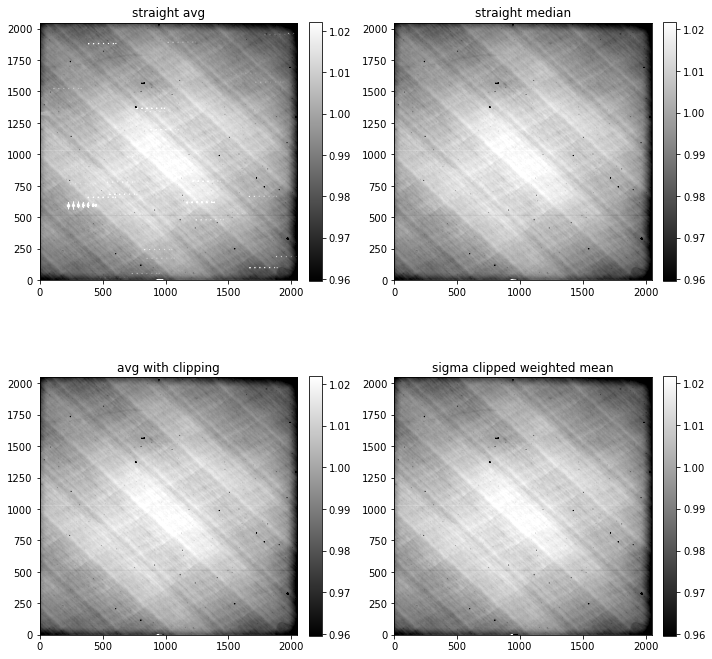

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)
show_image(master1, cmap='gray', ax=axes[0,0], fig=fig)
show_image(master2, cmap='gray', ax=axes[0,1], fig=fig)
show_image(master3, cmap='gray', ax=axes[1,0], fig=fig)
show_image(master4, cmap='gray', ax=axes[1,1], fig=fig)
axes[0,0].set_title('straight avg',fontsize=12)
axes[0,1].set_title('straight median',fontsize=12)
axes[1,0].set_title('avg with clipping',fontsize=12)
axes[1,1].set_title('sigma clipped weighted mean',fontsize=12)

Based on the images above, we can see that doing a straight average does not do a good job of removing the artifacts. But it's not possible to tell which of the other methods is the best. So let's compare the RMS values for each of the master frames produced using different methods.

In [15]:
print('straight avg: '+str(np.std(master1)),'\nstraight median: '+str(np.std(master2))
      ,'\navg with clipping: '+str(np.std(master3)),'\nsigma clipped weighted mean: '+
      str(np.std(master4)))

straight avg: 0.01551457760409798 
straight median: 0.01456056138002972 
avg with clipping: 0.014512995414096572 
sigma clipped weighted mean: 0.014470325249432207


It looks like the sigma clipped weighted mean gives the lowest RMS. So that is the best strategy to combine the flats. This makes sense because as already mentioned, this is the only method that weights the flat fields based on their count rates, while still removing artifacts within the frames (sigma clipping). 

### 2. Making a master flat for all filters using the chosen method above. 

In [16]:
# getting the paths to all the remaining flats; classified by filter
flat_list_halpha = np.hstack([["Imaging/a00"+str(i)+".fits" for i in np.arange(5,10,1)],
                             ["Imaging/a0"+str(j)+".fits"for j in np.arange(10,21,1)]])
flat_list_u = ["Imaging/a0"+str(i)+".fits" for i in np.arange(22,29,1)]
flat_list_b = ["Imaging/a0"+str(i)+".fits" for i in np.arange(32,43,1)]
flat_list_r = ["Imaging/a0"+str(i)+".fits" for i in np.arange(50,56,1)]
flat_list_i = ["Imaging/a0"+str(i)+".fits" for i in np.arange(57,63,1)]

Below is a function that does the overscan subtraction, trimming, and bias subtraction demonstrated in problem 1. Useful since we're dealing with multiple flats now.

In [17]:
# image reducing function
def reducer(frame,mod,mbias):
    images = [CCDData(fits.open(file)[0].data, unit='adu') for file in frame]
    sub = [subtract_overscan(images[i], overscan=images[i][:, 2101:2200],model=mod)
           for i in range(len(images))]
    trim = [trim_image(sub[i][:, 53:2101]) for i in range(len(sub))]
    bias_sub = [np.subtract(i,mbias) for i in trim]
    return bias_sub

In [18]:
# implement the reducing function on the flat frames
sub_flat_halpha = reducer(flat_list_halpha,mc2,master_bias)
sub_flat_u = reducer(flat_list_u,mc2,master_bias)
sub_flat_b = reducer(flat_list_b,mc2,master_bias)
sub_flat_r = reducer(flat_list_r,mc2,master_bias)
sub_flat_i = reducer(flat_list_i,mc2,master_bias)

In [19]:
# save flats that've been overscan & bias subtracted, and trimmed
save_reduced(np.arange(5,10,1),sub_flat_halpha[0:5],'a00','otz')
save_reduced(np.arange(10,21,1),sub_flat_halpha[5:],'a0','otz')
save_reduced(np.arange(22,29,1),sub_flat_u,'a0','otz')
save_reduced(np.arange(32,43,1),sub_flat_b,'a0','otz')
save_reduced(np.arange(50,56,1),sub_flat_r,'a0','otz')
save_reduced(np.arange(57,63,1),sub_flat_i,'a0','otz')

Below is a function that implements the master flat making strategy arrived at in problem 1 (i.e., sigma clipped weighted mean). 

In [20]:
# master flat making function
def master_flat(reduced,sig):
    scale = [i/np.mean(i) for i in reduced]
    clipped = sigma_clip(scale, sigma=sig, axis=0)
    w = [np.mean(np.array(i)) for i in reduced]
    master = np.ma.average(clipped, weights=np.array(w), axis=0)
    return master

In [21]:
# implementing the master flat making function
master_halpha = master_flat(sub_flat_halpha,2)
master_u = master_flat(sub_flat_u,2)
master_b = master_flat(sub_flat_b,2)
master_r = master_flat(sub_flat_r,2)
master_i = master_flat(sub_flat_i,2)
master_v = master4

Display the master flats for all the remaining filters. 

Text(0.5, 1.0, 'I master flat')

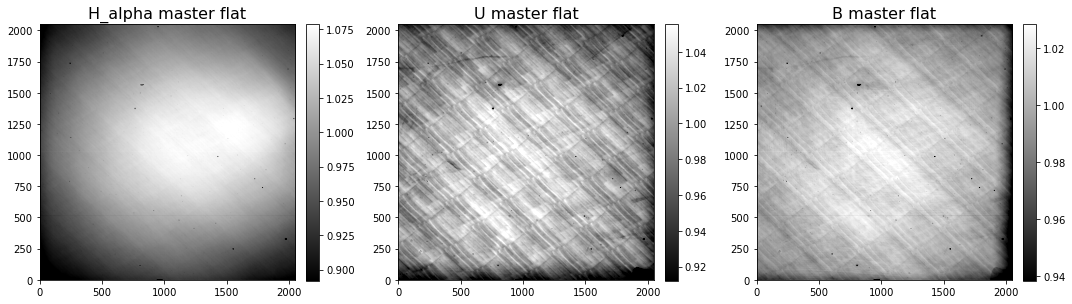

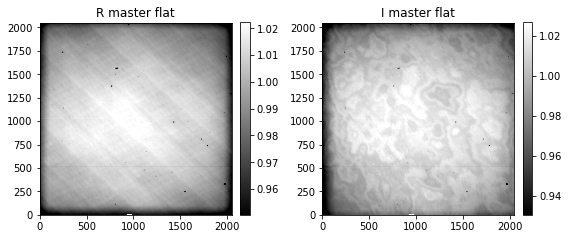

In [22]:
# display all of the master flats
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15), tight_layout=True)
show_image(master_halpha, cmap='gray', ax=ax1, fig=fig)
show_image(master_u, cmap='gray', ax=ax2, fig=fig)
show_image(master_b, cmap='gray', ax=ax3, fig=fig)
ax1.set_title('H_alpha master flat',fontsize=16)
ax2.set_title('U master flat',fontsize=16)
ax3.set_title('B master flat',fontsize=16)

fig, axes = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
show_image(master_r, cmap='gray', ax=axes[0], fig=fig)
show_image(master_i, cmap='gray', ax=axes[1], fig=fig)
axes[0].set_title('R master flat',fontsize=12)
axes[1].set_title('I master flat',fontsize=12)

It looks like the chosen strategy did a good job of removing any artifacts in the flats. 

### 3. Normalizing the master flat image for each filter 
The normalizing is done by dividing each master flat with its mean. This brings its mean to ~1. When later dividing an image with a master flat, using a normalized master flat helps keep track of the photon statistics within that image.  

In [23]:
# normalizing the master flats by their means
normal_halpha = master_halpha/np.mean(master_halpha)
normal_u = master_u/np.mean(master_u)
normal_b = master_b/np.mean(master_b)
normal_r = master_r/np.mean(master_r)
normal_i = master_i/np.mean(master_i)
normal_v = master_v/np.mean(master_v)

### 4. Dividing all science frames by the normalized flat fields.

The function below is used to add missing headers to the science frames. As shown a few cells down, this makes it easier to match the science frames' filters with the correct flats for division.

In [24]:
# function to add headers to fits files
def add_header(filt,imgtyp,ranges=np.arange(30,40,1),prefix='a0',path='reduced/'):
    # filt & imgtyp should be strings, prefix & ranges can be changed to fit naming scheme.
    for i in ranges:
        file = fits.open('Imaging/'+prefix+str(i)+".fits")
        head = file[0].header
        head["BIASSEC"]="[0:2048,2101:2200]"
        head["TRIMSEC"]="[0:2048,53:2101]"
        head["FILTER"]=str(filt)
        head["IMAGETYP"]=str(imgtyp)
        file.writeto(path+prefix+str(i)+".fits", overwrite=True)
    return print("done")

# Eg. add_header('Halpha','SkyFlat',ranges=np.arange(11,13,1))
#     fits.open("reduced/a012r.fits")[0].header  ---to check

Let's gather science frames that have the same filter and implement the function to add the missing headers (particularly the filters).

Note: files a220-a237 are missing in the imaging folder, so they've not been included here. And a194-a202 have not been included because they look like focus adjustment frames in the log.

In [25]:
# adding headers 
add_header('V','Science',ranges=np.hstack([np.arange(74,81,1),np.arange(85,87,1)])
           ,prefix='a0')

add_header('V','Science',ranges=np.hstack([np.arange(115,121,1),np.arange(134,136,1),
           np.arange(146,148,1),np.arange(157,160,1),np.arange(170,173,1),np.arange(183,185,1)
           ,np.arange(206,208,1),np.arange(215,218,1),np.arange(241,243,1)]),prefix='a')
           #(227,231) MISSING

add_header('Ha','Science',ranges=np.arange(91,93,1),prefix='a0')
add_header('Ha','Science',ranges=np.hstack([np.arange(127,130,1),np.arange(176,179,1)])
           ,prefix='a')# should I include 128 & 129 ???

add_header('U','Science',ranges=np.arange(81,83,1),prefix='a0')
add_header('U','Science',ranges=np.hstack([np.arange(130,132,1),np.arange(150,152,1),
            np.arange(162,164,1),np.arange(179,182,1),np.arange(191,193,1),
            np.arange(202,204,1),np.arange(237,239,1)]),prefix='a')

add_header('B','Science',ranges=np.arange(83,85,1),prefix='a0')
add_header('B','Science',ranges=np.hstack([np.arange(112,115,1),np.arange(132,134,1),
            np.arange(148,150,1),np.arange(160,162,1),np.arange(165,170,1),
            np.arange(189,191,1),np.arange(204,206,1),np.arange(218,221,1),
            np.arange(239,241,1)]),prefix='a')
            #(223,227) MISSING

add_header('R','Science',ranges=np.arange(87,89,1),prefix='a0')
add_header('R','Science',ranges=np.hstack([np.arange(121,124,1),np.arange(136,138,1),
            np.arange(144,146,1),np.arange(155,157,1),np.arange(173,176,1),
            np.arange(185,187,1),np.arange(208,210,1),np.arange(212,215,1),
            np.arange(243,245,1)]),prefix='a')
            #(231,233) & (235,237) MISSING
        
add_header('I','Science',ranges=np.arange(89,91,1),prefix='a0')
add_header('R','Science',ranges=np.hstack([np.arange(124,127,1),np.arange(138,140,1),
            np.arange(142,144,1),np.arange(153,155,1),np.arange(187,189,1),
            np.arange(210,212,1)]),prefix='a')
            #(233,235) MISSING


done
done
done
done
done
done
done
done
done
done
done
done


Now we divide each of our science frames with the normalized flat field of matching filter. The filters have to match because as seen in the master flat images at the end of problem 2, the flat frames taken with the different filters do not look the same. 

The flats are divided (instead of subtracted) because unlike a bias (which is just a DC offset that's added to every pixel), flats tell us the pixels' response to light. 

In [26]:
import glob

# grabbing all files with 'a' prefix
files = glob.glob('reduced/a*.fits')

# path contains files like 'a048otz.fits' & 'a085.fits'; 
# getting only those like the latter without the 'otz' suffix
science_list = [i for i in files if i[12]=='.'] 

# overscan/bias subtract and trim all of those images 
science_reduced = reducer(science_list,mc2,master_bias)

In [27]:
# divide each science frame with the master flat of matching filter
for i, ele in enumerate(science_list):
    if fits.getheader(ele)['FILTER']=='V':
        divided = np.divide(science_reduced[i],np.array(normal_v))
    if fits.getheader(ele)['FILTER']=='Ha':
        divided = np.divide(science_reduced[i],np.array(normal_halpha))       
    if fits.getheader(ele)['FILTER']=='U':
        divided = np.divide(science_reduced[i],np.array(normal_u))
    if fits.getheader(ele)['FILTER']=='B':
        divided = np.divide(science_reduced[i],np.array(normal_b))
    if fits.getheader(ele)['FILTER']=='R':
        divided = np.divide(science_reduced[i],np.array(normal_r))
    if fits.getheader(ele)['FILTER']=='I':
        divided = np.divide(science_reduced[i],np.array(normal_i))     

# save the now overscan/bias subtracted, trimmed, and flat fielded science frames
# the 'f' in the suffix corresponds to flat fielding
    if len(str(int(ele[9:12])))==2:
        fits.writeto('reduced/'+'a0'+str(int(ele[9:12]))+'otzf'+'.fits',divided,overwrite=True)
    
    if len(str(int(ele[9:12])))==3:
        fits.writeto('reduced/'+'a'+str(int(ele[9:12]))+'otzf'+'.fits',divided,overwrite=True)
        

Now let's display a raw science image and see what it looks like after overscan/bias subtraction & trimming, as well as after the flat-fielding. The effect of the flat-fielding is not very evident, but it looks like the image without flat-fielding has a slight blur (more contribution to the pixel values) compared to the one that has been flat-fielded. And this makes sense because that's what the flat fields are for––to correct for the pixel-to-pixel variations in the response of the CCD to light. 

Text(0.5, 1.0, 'overscan, bias, trimmed, \n & flat fielded')

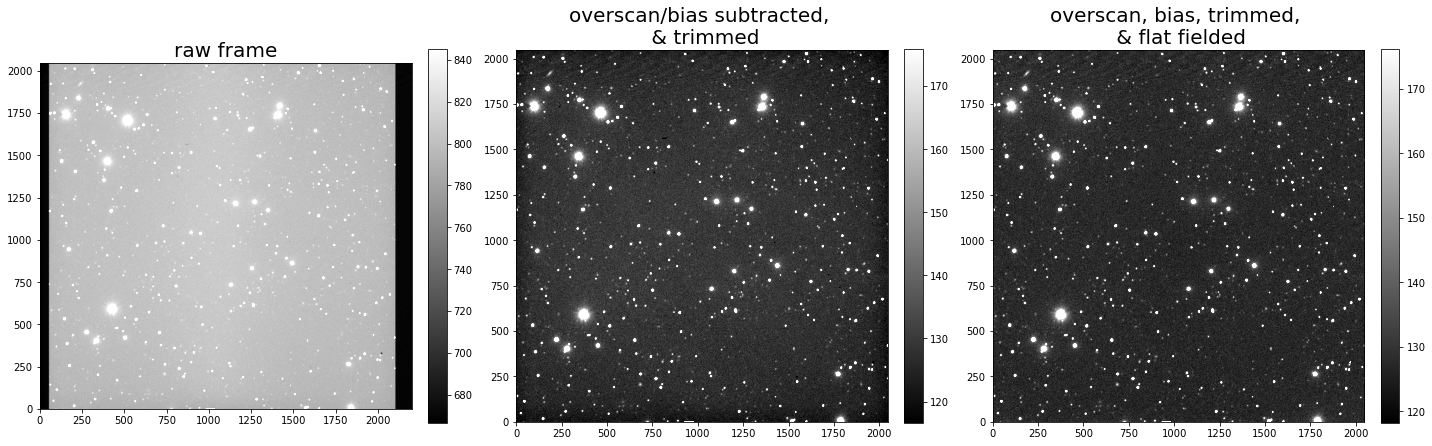

In [28]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,8), tight_layout=True)
show_image(fits.open('reduced/a244.fits')[0].data, cmap='gray', ax=ax1, fig=fig)
show_image(science_reduced[2], cmap='gray', ax=ax2, fig=fig)
show_image(fits.open('reduced/a244otzf.fits')[0].data, cmap='gray', ax=ax3, fig=fig)
ax1.set_title('raw frame',fontsize=20)
ax2.set_title('overscan/bias subtracted, \n & trimmed',fontsize=20)
ax3.set_title('overscan, bias, trimmed, \n & flat fielded',fontsize=20)

### 5. Computing the gain and read noise using flat field and bias images
From Howell's Handbook of CCD Astronomy,

$$Gain=\dfrac{(F_1+F_2)-(B_1+B_2)}{\sigma_{F_1-F_2}^2-\sigma_{B_1-B_2}^2}$$

$$Read noise=\dfrac{G.\sigma_{B_1-B_2}}{\sqrt{2}}$$

To determine the gain and read noise values, it's better not to use whole images. This is because the edges of an image (excluding the overscan region) might have very large/small values due to CCD readout properties (Howell, pg.72). Therefore, we'll crop out a region around the center of the CCD in each image and use that in the gain & readnoise calculations.

Notice also how the flat images used are flat-fielded (are divided by a normalized master flat). This is because a raw flat frame has both pixel-to-pixel variations and read noise contributions to its pixel values. And a master flat is made of many flats, so it has information about the pixel-to-pixel variations within the CCD. So dividing the flat by a normalized master flat helps in getting rid of the pixel-to-pixel variations. 

In [29]:
# taking reduced flats and biases (i.e., have been overscan/bias subtracted & trimmed)
# both flats are taken in the V filter, have 12s exp. times, and are flat-fielded 
f1,f2 = np.array(np.divide(sub_flat[2],normal_v)), np.array(np.divide(sub_flat[3],normal_v))
b1,b2 = np.array(biases[0]),np.array(biases[1])

In [30]:
# function to crop out a region around the center of the CCD
def crop(dat):
    row = dat.shape[0]
    col = dat.shape[1]
    row_center = int(row/2)
    col_center = int(col/2)
    square_region = dat[(row_center-100):(row_center+100),
                         (col_center-100):(col_center + 100)]
    return square_region

# crop all four frames
f11, f22, b11, b22 = crop(f1),crop(f2),crop(b1),crop(b2)

In [31]:
# calculating the gain using the formula from above
gain = ((np.mean(f11)+np.mean(f22))-(np.mean(b11)+np.mean(b22)))/(np.var(f11-f22)-np.var(b11-b22))

print('gain: '+str(gain))

gain: 1.6118715891499578


Now lets find the gain from the slope of signal vs variance. The signal is the average count in a flat image. Here, we find the mean and variance of the cropped region in each flat. We'll use 4 V-filter flats with increasing exposure time. The slope is found using numpy polyfit.

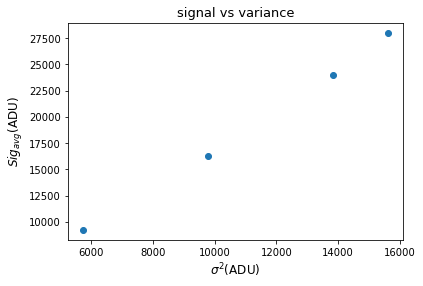

gain: 1.8972469455150256


In [32]:
# function for flat-fielding, cropping, & finding the mean
def average(data, master=normal_v):
    divide = np.divide(data,master)
    avg = np.mean(crop(divide))
    return avg

# function for flat-fielding, cropping, & finding the variance
def sig2(data, master=normal_v):
    divide = np.divide(data,master)
    v = np.var(crop(divide))
    return v

y = np.array([average(sub_flat[0]),average(sub_flat[1]),average(sub_flat[2])
             ,average(sub_flat[3])])
x = np.array([sig2(sub_flat[0]),sig2(sub_flat[1]),sig2(sub_flat[2]),sig2(sub_flat[3])])

# do a numpy polyfit to find the slope (i.e., gain) 
m,b = np.polyfit(x,y,1)
gain1 = m

plt.scatter(x,y)
plt.title('signal vs variance',fontsize=13)
plt.xlabel('$\sigma^2$(ADU)',fontsize=12)
plt.ylabel('$Sig_{avg}$(ADU)',fontsize=12)
plt.show()

print('gain: '+str(m))

This gain value of ~2e-/ADU is slightly better that the ~1.6e-/ADU found using the formula from Howell. For reference, the gain of the CCD according to the WIRO-Prime website is 2.5e-/ADU.

Now let's try to calculate the read noise using the gain obtained from the slope of signal vs variance.

In [33]:
rn = gain1*np.std(b11-b22)/np.sqrt(2)
print('read noise: '+str(rn)+'\n', '\nstd: '+str(np.std(b11-b22)))

read noise: 16.826351573835165
 
std: 12.542412919534783


This read noise value of approx. 17 electrons is rather high compared to the 4.5 electrons read noise given on WIRO-Prime. There's clearly something in the biases that's producing a problematic signal, because we need that standard deviation to be small in order to get a better read noise value. I checked this standard deviation by taking different sections of the bias images, but it remained around the same value (~12). Therefore, if we want to get a better read noise, more needs to be done in the bias calibration process to bring that value down. 